<a href="https://colab.research.google.com/github/sjavierm/TP2-SOA/blob/main/HPC/cuaderno_2_miercoles_grupo02_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1-Introducción**
El tema elegido para el segundo ejercicio es el de "reconocimiento facial" que utiliza modelos de deep learning para su realizacion. Mas especificamente utilizamos un detector que esta formado por la combinacion de 3 modelos de redes neuronales que van refinando, de forma secuencial, las detecciones generadas.

#**2-Armado de ambiente**

##2.1 Se toma la direccion web de una imagen para tenerla disponible para la resolucion del ejercicio.

In [ ]:
#@markdown ---
#url_imagen = "https://editorial.uefa.com/resources/025e-0fbb285038b4-447a9597b41d-1000/fc_barcelona_v_juventus_-_uefa_champions_league.jpeg" #@param {type:"string"}
url_imagen = "https://editorial.uefa.com/resources/025e-0fbb285038b4-447a9597b41d-1000/fc_barcelona_v_juventus_-_uefa_champions_league.jpeg" #@param {type:"string"}
#@markdown ---
!wget {url_imagen} -O imagen.jpg

--2021-07-04 15:26:13--  https://editorial.uefa.com/resources/025e-0fbb285038b4-447a9597b41d-1000/fc_barcelona_v_juventus_-_uefa_champions_league.jpeg
Resolving editorial.uefa.com (editorial.uefa.com)... 184.84.64.57, 2600:1408:7400:585::274d, 2600:1408:7400:58e::274d
Connecting to editorial.uefa.com (editorial.uefa.com)|184.84.64.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177540 (173K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 173.38K   797KB/s    in 0.2s    

2021-07-04 15:26:14 (797 KB/s) - ‘imagen.jpg’ saved [177540/177540]



##2.2 Se instala en el cuaderno el modulo CUDA de python

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 31.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=d2d763cae9f2c81a84c86b545701260469522a9423c82152cc7dde85a6fa38dc
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=045723e8b96f70073ba6999a6d9ee4d32789165429bb9d5cf876702950b0091f
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


##2.3 Se instala en el cuaderno el modulo MTCNN para el reconocimiento facial.

In [ ]:
!pip install facenet-pytorch 

from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization

     |████████████████████████████████| 1.9MB 30.7MB/s 


#**3-Desarrollo**

In [ ]:
%matplotlib inline
import torch
from facenet_pytorch import MTCNN

import  matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

In [ ]:
# Cargamos la imagen en un parametro
img_nombre = 'imagen.jpg'
try:
  image = Image.open( img_nombre ) 
  if(image.format != 'JPEG'):
    raise Exception("El formato debe ser jpg")
except FileNotFoundError:
  sys.exit("No se encontró la imagen. Primero debe ejecutar el comando que descarga la imagen en la sección de armado del ambiente")
except Exception as error:
  sys.exit(error)

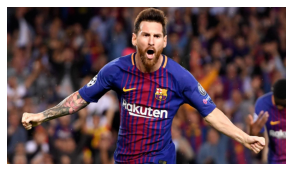

In [ ]:
# Mostramos la imagen original
plt.figure(figsize=(5, 4))
plt.imshow(image)
plt.axis('off');

In [ ]:
# Deteccion con el modulo CUDA
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [ ]:
# Detector MTCNN
mtcnn = MTCNN(
            select_largest = True,
            min_face_size  = 20,
            thresholds     = [0.6, 0.7, 0.7],
            post_process   = False,
            image_size     = 160,
            device         = device
        )

In [ ]:
# Deteccion de bounding box y landmarks
boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)
print('Bounding boxes:', boxes)
print('Probability:', probs)
print('landmarks:', landmarks)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Bounding boxes: [[ 842.318    103.99387 1021.1599   364.21204]
 [ 307.3157   824.44366  428.57486  962.9093 ]]
Probability: [0.99986744 0.75973547]
landmarks: [[[902.0442  191.84412]
  [977.0646  198.36682]
  [936.2735  244.61038]
  [904.369   295.54166]
  [958.1285  301.6842 ]]

 [[344.7944  875.0491 ]
  [390.4044  862.87146]
  [370.24655 904.4794 ]
  [364.51068 930.912  ]
  [399.59702 923.685  ]]]


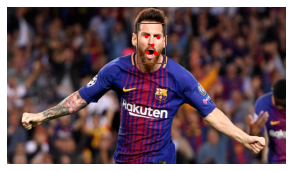

In [ ]:
# Representación con matpolib
# En punto de origen (0,0) de una imagen es la esquina superior izquierda
box = boxes[0]
landmark = landmarks[0]
fig, ax  = plt.subplots(figsize=(5, 4))
ax.imshow(image)
ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
rect = plt.Rectangle(
            xy     = (box[0], box[1]),
            width  = box[2] - box[0],
            height = box[3] - box[1],
            fill   = False,
            color  = 'red'
       )
ax.add_patch(rect)
ax.axis('off');

#**4-Conclusión**
Como conclusion final podemos decir que luego de haber utilizado conceptos de deep learning podemos decir que es un tema que deberia ser la base del aprendizaje para los futuros ingenieros en informatica ya que durante los proximos años veremos estos mismos conceptos aplicados en numerosos productos/mecanismos/procesos etc.

#**5-Bibliografia**
[Ciencia de datos](https://www.cienciadedatos.net/documentos/py34-reconocimiento-facial-deeplearning-python.html)


[facenet-pytorch](https://github.com/timesler/facenet-pytorch)

[MTCNN](https://pypi.org/project/mtcnn/)